In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### try dask

In [2]:
import dask.dataframe as dd

cols_train = list(pd.date_range("2015-07-01","2017-09-10",freq="D").strftime("%Y-%m-%d"))
train = dd.read_csv("train_2.csv", assume_missing=True, blocksize="16M").fillna(0).astype(
    dtype={ii:np.uint32 for ii in cols_train})
#train.head()

<AxesSubplot:>

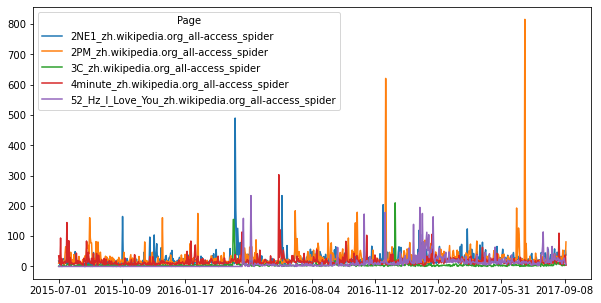

In [3]:
f, ax = plt.subplots(figsize=(10,5))

train.head().set_index("Page").T.plot(ax=ax)

In [4]:
agent = train.Page.apply(lambda x: x.split("_")[-1], meta=("agent",str))
access = train.Page.apply(lambda x: x.split("_")[-2], meta=("access",str))
wikiproject = train.Page.apply(lambda x: x.split("_")[-3],  meta=("wikiproject",str))
page_name = train.Page.apply(lambda x: "_".join(x.split("_")[:-3]), meta=("page_name",str))

In [5]:
#wikiproject.value_counts().compute()

### SMAPE

In [6]:
def smape(A, F):
    return 100/A.size * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F) + np.finfo(float).eps))

In [7]:
df = train.head(1000)

In [8]:
df.head().values[:,1:]

array([[18, 11, 5, ..., 23, 54, 38],
       [11, 14, 15, ..., 23, 13, 81],
       [1, 0, 1, ..., 4, 7, 6],
       [35, 13, 10, ..., 30, 38, 4],
       [0, 0, 0, ..., 14, 8, 7]], dtype=object)

In [9]:
def last_repeated_estimator(ts_prev):
    """ ts_prev : matrix (m, Ts) """
    return np.tile(ts_prev[:,-1].reshape(-1,1), (1,62))

In [10]:
Dnum = df.fillna(0).values[:,5:]

In [11]:
smape(np.zeros_like(Dnum), Dnum)

193.2005006257822

In [12]:
Mmean = np.tile(np.mean(Dnum, 1).reshape(-1,1) , (1,Dnum.shape[1]))
smape(Mmean, Dnum)

56.96895863503986

### ouput

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd


key = dd.read_csv("key_2.csv", blocksize="16M").set_index("Page")

In [14]:
out_date = pd.date_range(start="2017-09-13", end="2017-11-13", freq="1D").strftime("%Y-%m-%d").to_list()

In [15]:
def output_form(_df, _estimator=None):
    """ return a serie indexed by Page """
    out_date = pd.date_range(start="2017-09-13", end="2017-11-13", freq="1D").strftime("%Y-%m-%d").to_list()
    num_hist = _df.values[:,1:]
    num_pred = _estimator(num_hist)
    ret = pd.DataFrame(num_pred, columns=out_date, index=_df["Page"]).stack().rename("Visits")
    ret.index = [ii[0]+"_"+ii[1] for ii in ret.index]
    return pd.DataFrame(ret)

#output_form(df.head(), last_repeated_estimator)

In [16]:
dd_out = train.map_partitions(output_form, _estimator=last_repeated_estimator)

In [17]:
result = key.merge(dd_out, left_index=True, right_index=True, how="outer")

In [18]:
result.to_csv("subm.csv", encoding='utf-8', index=False, single_file=True, chunksize=10000)

KeyboardInterrupt: 